# Single Particle Chromaticity

In [24]:
# %reset -f
import sys
import numpy as np
from LebedevHelper import *

import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import scipy.special as spec
from scipy import signal
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate

import pickle as pkl
import struct 


# Plotting preparation
sys.path.append('../')
from plot_configuration import *
np.set_printoptions(precision=3,suppress=True) 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
plt.close('all')
np.set_printoptions(precision=5,suppress=False) 

# Combi preparation
sys.path.append('/home/sfuruset/hdd/05_Combi_related/05_COMBIp/src/python')

In [25]:

%matplotlib notebook
dir_save = '01_Output/'
pltdir = '04_Plots_Diffusion/'

# Test PSD

<IPython.core.display.Javascript object>


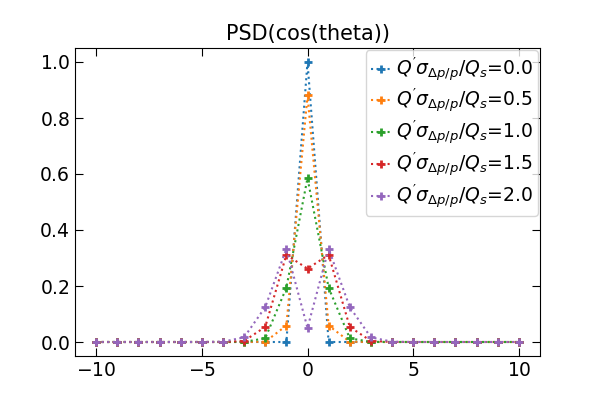

1.0 [ 0. -0.  0. -0.  0. -0.  0. -0.  0. -0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
1.0 [ 2.61318e-13 -1.04468e-11  3.75822e-10 -1.20159e-08  3.36068e-07
 -8.05363e-06  1.60736e-04 -2.56373e-03  3.06040e-02 -2.42268e-01
  9.38470e-01  2.42268e-01  3.06040e-02  2.56373e-03  1.60736e-04
  8.05363e-06  3.36068e-07  1.20159e-08  3.75822e-10  1.04468e-11
  2.61318e-13]
1.0 [ 2.63062e-10 -5.24925e-09  9.42234e-08 -1.50233e-06  2.09383e-05
 -2.49758e-04  2.47664e-03 -1.95634e-02  1.14903e-01 -4.40051e-01
  7.65198e-01  4.40051e-01  1.14903e-01  1.95634e-02  2.47664e-03
  2.49758e-04  2.09383e-05  1.50233e-06  9.42234e-08  5.24925e-09
  2.63062e-10]
0.9999999999999998 [ 1.47433e-08 -1.95567e-07  2.33207e-06 -2.46798e-05  2.28013e-04
 -1.79942e-03  1.17681e-02 -6.09640e-02  2.32088e-01 -5.57937e-01
  5.11828e-01  5.57937e-01  2.32088e-01  6.09640e-02  1.17681e-02
  1.79942e-03  2.28013e-04  2.46798e-05  2.33207e-06  1.95567e-07
  1.47433e-08]
0.9999999999999993 [ 2.51539e-07 -2.49234e-06

Text(0.5, 1.0, 'PSD(cos(theta))')

In [28]:

# bessel = spec.jv(order,argument)
# cos(a+x*cos(b)) = sum p_l * cos(a+b*l)
# x=0: p_0=1, p_n=0


plt.figure()
for x in np.linspace(0,2,5):
    l=np.arange(-10,11)
    p_l = spec.jv(l,x)
    print(np.sum(p_l**2),p_l)
    
    plt.plot(l,p_l**2,':+',label='$Q\'\sigma_{\Delta p/p}/Q_s$=%.1f'%x)
plt.legend(loc=0)
plt.title('PSD(cos(theta))')

10000
4.0


<IPython.core.display.Javascript object>


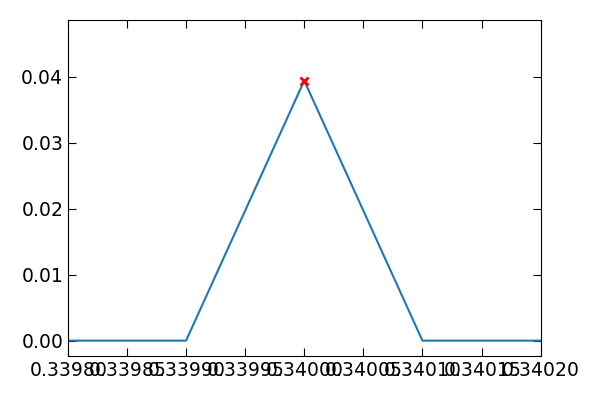

0.15772797147489018


<IPython.core.display.Javascript object>


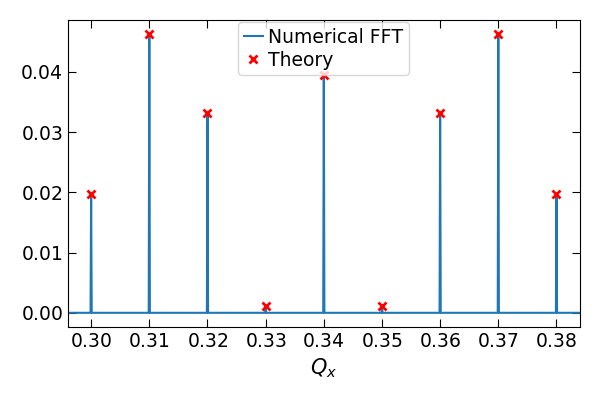

0.15772797147489018


In [29]:
Nt = 1024*4#256
Qp = 8 *5 *1
Qs = 0.002 *5
Nt= int(100/Qs)
print(Nt)
Qx = 0.34
pi2 = 2*np.pi
t = np.arange(Nt)

A_delta = 1e-3
delta    = np.cos(pi2*Qs*t)*A_delta
intdelta = np.sin(pi2*Qs*t)*A_delta/(pi2*Qs)

print(Qp*A_delta/Qs)

x = np.cos(pi2*(Qx*t+np.cumsum(Qp*delta)))
# x = np.cos(pi2*(Qx*t+Qp*intdelta))
# x = np.cos(pi2*Qx*t) - np.sin(pi2*Qx*t)*pi2*Qp*intdelta

# plt.figure()
# plt.plot(t,x)

fft = np.fft.fft(x,norm="ortho")#/Nt#,norm="ortho"
freq=np.fft.fftfreq(Nt,d=1)
fft =np.fft.fftshift(fft)
freq=np.fft.fftshift(freq)

# fft,freq = signal.welch(x,fs=1)

for fac in [0.0002,4.4*Qs]:
    plt.figure()
    plt.plot(freq,np.abs(fft)**2/Nt,label='Numerical FFT')
    plt.xlim(Qx-fac,Qx+fac)
    plt.tight_layout()
    
    #Theory
    arg=Qp*A_delta/Qs
    l=np.arange(-10,11)
    p_l = spec.jv(l,arg)
    print(p_l[10]**2)
    plt.plot(Qx+Qs*l,p_l**2 * 1/4,'rx',label='Theory')
    
#     plt.ylim(0,1e6)
plt.xlabel(r'$Q_x$')
plt.legend(loc=0)
plt.tight_layout()

X 1.0


<IPython.core.display.Javascript object>


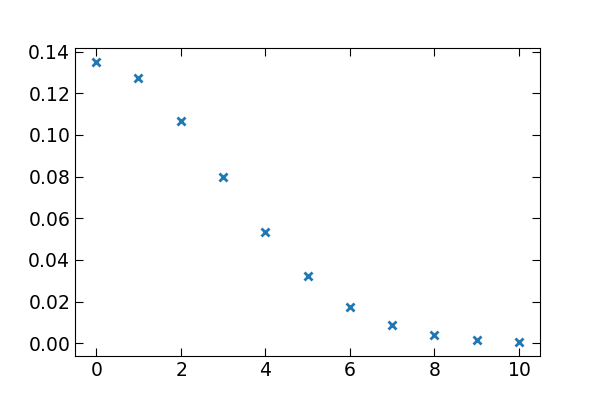

<IPython.core.display.Javascript object>


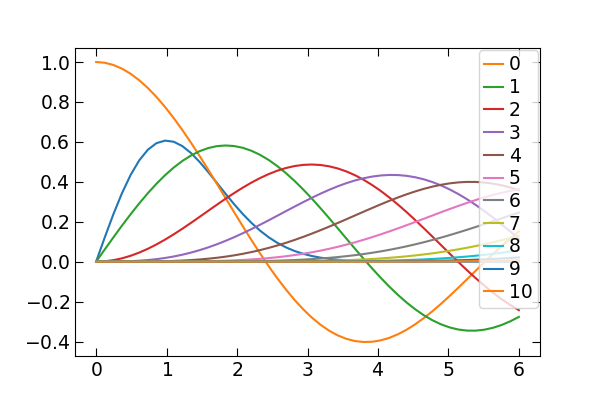

In [30]:
# Need to average bessel function over the distribution
sigma_dpp = 1e-4
Qp=100 *2
Qs=0.02
sigma_x = Qp*sigma_dpp/Qs
print('X',sigma_x)



def find_DiffusionSidebandWeight(sigma_x,maxOrder=30,tol=1e-3):
    """
        Function to find the weight of the sideband 
        Taken as average bessel function squared over the longitudinal gaussian distribution
    """
    xs = np.linspace(0,6,50)*sigma_x
    phi_x = xs/sigma_x**2 * np.exp(-xs**2/sigma_x**2*.5)
    
    orders = np.arange(maxOrder+1)
    factors = np.zeros(maxOrder+1)
    if sigma_x>0:
        for m in orders:
            ys=spec.jv(m,xs)
            mean = sc.integrate.simps(ys**2*phi_x,x=xs,even='first')
            factors[m]=mean
            if factors[m]/factors[0]< tol:
                print('Need no more',m)
                factors = factors[:m]
                orders = orders[:m]
                break
    else:
        factors = np.array([1])
        orders  = np.array([0])
    return factors,orders



# Check if correct, buth the numbers I print should be multiplied with the peak value at that sideband!!!

factors,orders = find_DiffusionSidebandWeight(3,maxOrder=10)
plt.figure()
plt.plot(orders,factors,'x')


xs = np.linspace(0,6,50)*sigma_x
phi_x = xs/sigma_x**2 * np.exp(-xs**2/sigma_x**2*.5)
plt.figure()
plt.plot(xs,phi_x)
for l in orders:
    ys=spec.jv(l,xs)
    plt.plot(xs,ys,label=l)
plt.legend(loc=0)


<IPython.core.display.Javascript object>


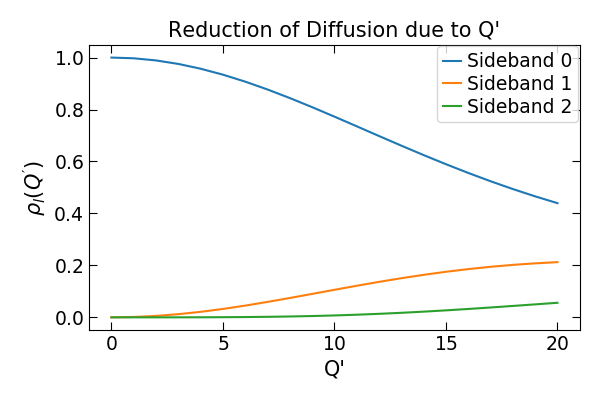

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Need no more 2


In [62]:
sigma_dpp = 1e-4
Qs=0.0019

plt.figure()
Qps = np.arange(21.0)
weights = np.zeros((21,3))
for i in range(21):
    Qp = Qps[i] 
    sigma_x = Qp*sigma_dpp/Qs
    factors,orders = find_DiffusionSidebandWeight(sigma_x,maxOrder=2,tol=1e-5)
    nentry=np.size(factors)
    weights[i,:nentry]= factors[:3]

for i in range(3):
    plt.plot(Qps,weights[:,i],label='Sideband %d'%i)
plt.xlabel("Q'")
plt.ylabel(r"$\rho_l(Q')$")
plt.title("Reduction of Diffusion due to Q'")
plt.legend(loc=0)
plt.tight_layout()


Need no more 4
X 0.7894736842105263
factors: [0.58955 0.17534 0.02689 0.00277]


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


<IPython.core.display.Javascript object>


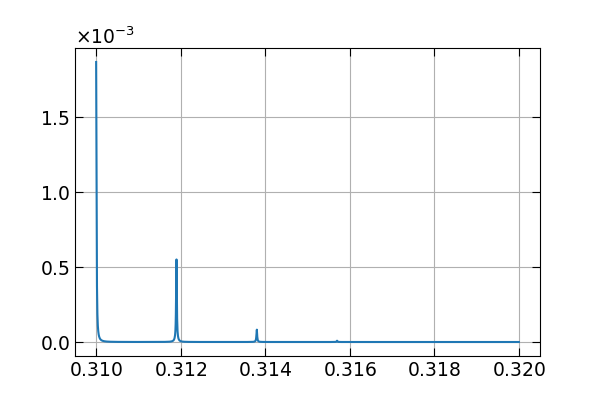

In [31]:
freq = np.linspace(.31,0.32,2000)
sigma_n=1e-7
Qp=100 * 1
Qp=15
Q0=0.31
gamma=1e-5
Qs=0.0019
sigma_dpp=1e-4
X=Qp*sigma_dpp/Qs


factors,orders = find_DiffusionSidebandWeight(X,maxOrder=50,tol=1e-3)
print('X',X)
print('factors:',factors)

dt = 1 # time between kicks
PSD_noise = sigma_n**2 /dt
D = np.zeros_like(freq)
Qcom = Q0 - 1j*gamma
for m in orders:
    for sign in [-1,1][m==0:]:
        freqm = freq         + sign*m*Qs*0
        Qcom = Q0 - 1j*gamma + sign*m*Qs*1
        D += factors[m] * PSD_noise/(2) * \
                np.abs(Qcom)**2/(pi2**2*((freqm**2-np.real(Qcom**2))**2+np.imag(Qcom**2)**2)) 

plt.figure()
plt.plot(freq,D * 10000)
nbands = 3
# plt.xlim(Q0-nbands*Qs,Q0+nbands*Qs)
plt.grid(True)

# Expression in time domain

<IPython.core.display.Javascript object>


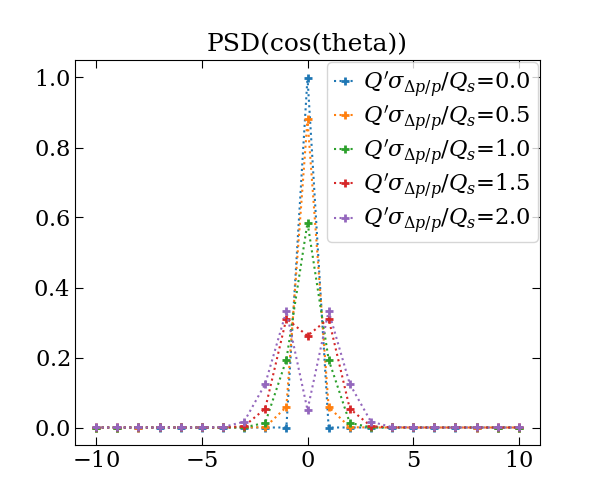

1.0 [ 0. -0.  0. -0.  0. -0.  0. -0.  0. -0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
1.0 [ 2.61318e-13 -1.04468e-11  3.75822e-10 -1.20159e-08  3.36068e-07
 -8.05363e-06  1.60736e-04 -2.56373e-03  3.06040e-02 -2.42268e-01
  9.38470e-01  2.42268e-01  3.06040e-02  2.56373e-03  1.60736e-04
  8.05363e-06  3.36068e-07  1.20159e-08  3.75822e-10  1.04468e-11
  2.61318e-13]
1.0 [ 2.63062e-10 -5.24925e-09  9.42234e-08 -1.50233e-06  2.09383e-05
 -2.49758e-04  2.47664e-03 -1.95634e-02  1.14903e-01 -4.40051e-01
  7.65198e-01  4.40051e-01  1.14903e-01  1.95634e-02  2.47664e-03
  2.49758e-04  2.09383e-05  1.50233e-06  9.42234e-08  5.24925e-09
  2.63062e-10]
0.9999999999999998 [ 1.47433e-08 -1.95567e-07  2.33207e-06 -2.46798e-05  2.28013e-04
 -1.79942e-03  1.17681e-02 -6.09640e-02  2.32088e-01 -5.57937e-01
  5.11828e-01  5.57937e-01  2.32088e-01  6.09640e-02  1.17681e-02
  1.79942e-03  2.28013e-04  2.46798e-05  2.33207e-06  1.95567e-07
  1.47433e-08]
0.9999999999999993 [ 2.51539e-07 -2.49234e-06

Text(0.5, 1.0, 'PSD(cos(theta))')

In [8]:
# bessel = spec.jv(order,argument)
# cos(a+x*cos(b)) = sum p_l * cos(a+b*l)
# x=0: p_0=1, p_n=0

a = 1
b = 1
x = 1


plt.figure()
for x in np.linspace(0,2,5):
    l=np.arange(-10,11)
    p_l = spec.jv(l,x)
    print(np.sum(p_l**2),p_l)
    
    plt.plot(l,p_l**2,':+',label='$Q\'\sigma_{\Delta p/p}/Q_s$=%.1f'%x)
plt.legend(loc=0)
plt.title('PSD(cos(theta))')

0.39999999999999997
-10.0
-9.0
-8.0
-7.0
-6.0
-5.0
-4.0
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


<IPython.core.display.Javascript object>


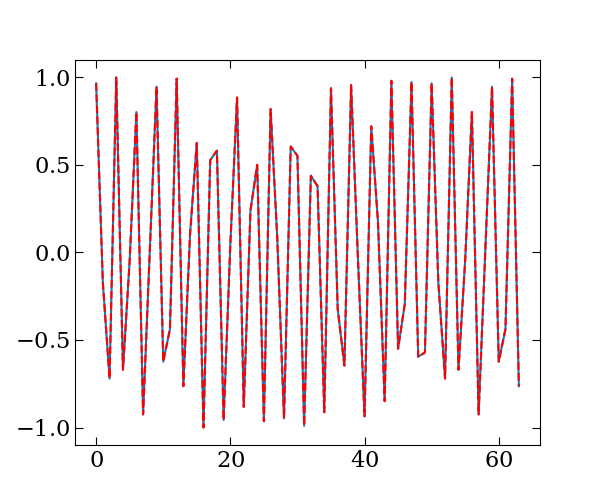

In [48]:
Nt = 1024*1/16 #256
Qp = 8 *5 *1
Qs = 0.002 *50
# Nt= int(100/Qs)
# print(Nt)
Qx = 0.34
pi2 = 2*np.pi
t = np.arange(Nt)
phiz0 = .834

A_delta = 1e-3
delta    = np.cos(phiz0-pi2*Qs*t)*A_delta
intdelta = np.sin(phiz0-pi2*Qs*t)*A_delta/(pi2*Qs)
delta    = -np.sin(phiz0-pi2*Qs*t)*A_delta
intdelta = -np.cos(phiz0-pi2*Qs*t)*A_delta/(pi2*Qs)
intdelta2= np.sin(-phiz0+pi2*Qs*t -np.pi/2) *A_delta/(pi2*Qs)

XX = Qp*A_delta/Qs
print(XX)

x1 = np.cos(pi2*(Qx*t+np.cumsum(Qp*delta)))
x1 = np.cos(pi2*(Qx*t+Qp*intdelta))


x2 = np.zeros_like(x1)
for l in np.arange(-10,10.1,1):
    print(l)
#     x2 += np.cos(pi2*(Qx+ l*Qs)*t) * spec.jv(abs(l),XX)
    x2 += np.cos(pi2*(Qx + l*(Qs))*t - l*(phiz0+np.pi/2) ) * spec.jv((l),XX)

plt.figure()
plt.plot(t,x1)
plt.plot(t,x2,'r--')

<IPython.core.display.Javascript object>


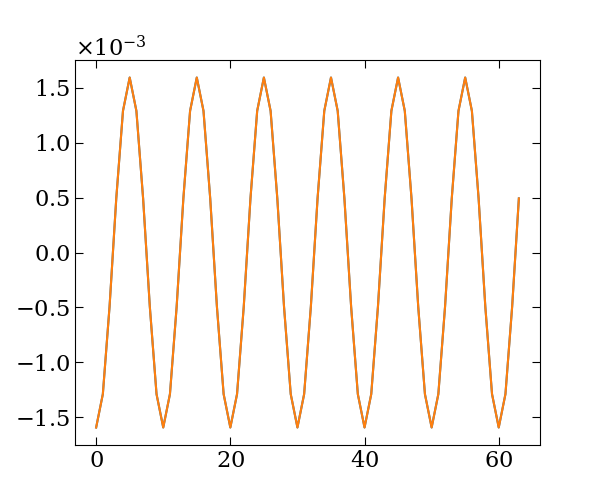

In [38]:
plt.figure()
plt.plot(intdelta)
plt.plot(intdelta2)

# Compare to COMBIp simulations

In [5]:
from parseInput import *
import glob

In [6]:
inputdir = "/home/sfuruset/hdd/05_Combi_related/01_output/USHO/"

def getDeltaAct1D(folder,T = 1e4):
    try:
        infile = glob.glob(inputdir+folder+'/*in')[0]
    except:
        print('Could not find an ''.in''-file :',inputdir+folder+'/*in')
        return 1
    print('Infile path: %s'%infile)
    indic = parseIn(infile)
#     print('Infile content: %s'%indic)
    gamma =indic['energy_B1']/indic['mass_B1']
    beta =indic['betastar_H']
    emitX=indic['emitn_B1H']
    sigx = np.sqrt(beta*emitX/gamma)
    sigp = sigpx = sigx/beta
    
    # Get chane
    for i in range(2):
        myFile = open(inputdir+folder+'/B1b1_t%d.beam'%[T*0,1*T][i],'rb');
        print('Input from: ',myFile.name)
        ncoord = 7;
        npart_beam = int(1e6)
        coords = np.reshape(struct.unpack('d'*int(ncoord*npart_beam),myFile.read()),(npart_beam,ncoord));
        myFile.close();
        if i==0: jx0  = 0.5*(((coords[:,0]-0)/sigx)**2+((coords[:,1]-0)/sigpx)**2);
        else:    jx   = 0.5*(((coords[:,0]-0)/sigx)**2+((coords[:,1]-0)/sigpx)**2);

    nturn = T


    nbin2 = 200
    jxmax = 6

    diff = jx-jx0
    var  = (diff)**2/(2*nturn*jx0)

    N,xedges = np.histogram(jx0,nbin2,range=[0,jxmax])
    D,xedges = np.histogram(jx0,nbin2,range=[0,jxmax],weights=diff/nturn);
    V,xedges = np.histogram(jx0,nbin2,range=[0,jxmax],weights=var);
    xcenter = (xedges[1:]+xedges[:-1])/2
    return xcenter,D,V,N

def find_DiffusionSidebandWeight(sigma_x,maxOrder=10):
    """
        Function to find the weight of the sideband 
        Taken as average bessel function squared over the longitudinal gaussian distribution
    """
    xs = np.linspace(0,6,50)*sigma_x
    phi_x = xs/sigma_x**2 * np.exp(-xs**2/sigma_x**2*.5)
    
    orders = np.arange(maxOrder+1)
    factors = np.zeros(maxOrder+1)
    if sigma_x>0:
        for m in orders:
            ys=spec.jv(m,xs)
            mean = sc.integrate.simps(ys**2*phi_x,x=xs,even='first')
            factors[m]=mean
    else:
        factors[0]=1
    return factors,orders

def find_DiffusionSideband(Qs,sigdpp,Qp,Qmode,PSD_noise, Qx=0.31,a=0.01,Jtest = np.linspace(0,1,601) * 6):
    X = sigdpp*Qp/Qs
    ReQ = Qmode.real
    ImQ = Qmode.imag
    print('X',X)
    
    factors,orders = find_DiffusionSidebandWeight(X,maxOrder=30)

    freq = Qx + a * Jtest
    D = np.zeros_like(freq)
    for m in orders:
        for sign in [-1,1][m==0:]:
            Qcom = ReQ+sign*m*Qs + 1j*ImQ
            D += factors[m] * PSD_noise/(2) * \
                    np.abs(Qcom)**2/(pi2**2*((freq**2-np.real(Qcom**2))**2+np.imag(Qcom**2)**2)) 
    return Jtest,D

def locavg(x,n=3):
    res = x.copy()
    for i in range(n):
        res += (np.roll(x,i+1) + np.roll(x,-i-1))
    if n>0:
        res[:n]=res[n]
        res[-n:]=res[-n-1]
        res = res/(2*n+1)
    return res

<IPython.core.display.Javascript object>


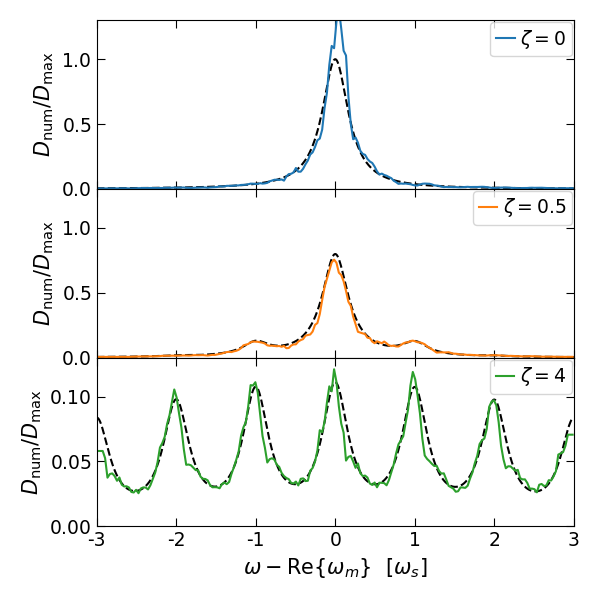

Width J = abs(ImQ/a) = 0.200


<IPython.core.display.Javascript object>


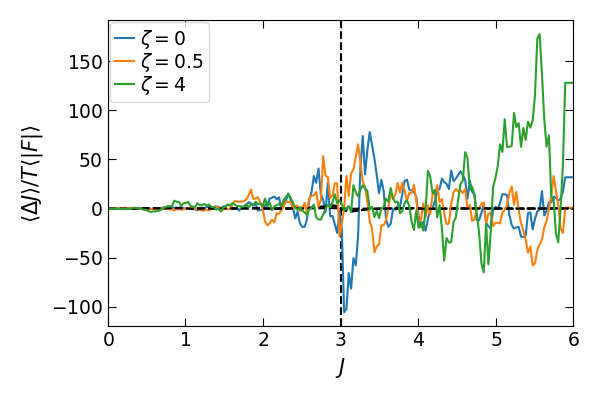

Dmax=7.92e-12
FT = 8.9e-07*8.0e+01 = 7.10e-05
X 0.0
T2e4_Np1e6_Qp0_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3
Infile path: /home/sfuruset/hdd/05_Combi_related/01_output/USHO/T2e4_Np1e6_Qp0_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3/IN.in
Input from:  /home/sfuruset/hdd/05_Combi_related/01_output/USHO/T2e4_Np1e6_Qp0_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3/B1b1_t0.beam


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:74: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Input from:  /home/sfuruset/hdd/05_Combi_related/01_output/USHO/T2e4_Np1e6_Qp0_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3/B1b1_t20000.beam
Dmax=7.92e-12
FT = 8.9e-07*8.0e+01 = 7.10e-05
X 0.5
Need no more 3
T2e4_Np1e6_Qp50_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3
Infile path: /home/sfuruset/hdd/05_Combi_related/01_output/USHO/T2e4_Np1e6_Qp50_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3/IN.in
Input from:  /home/sfuruset/hdd/05_Combi_related/01_output/USHO/T2e4_Np1e6_Qp50_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3/B1b1_t0.beam
Input from:  /home/sfuruset/hdd/05_Combi_related/01_output/USHO/T2e4_Np1e6_Qp50_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3/B1b1_t20000.beam
Dmax=7.92e-12
FT = 8.9e-07*8.0e+01 = 7.10e-05
X 4.0
Need no more 16
T2e4_Np1e6_Qp400_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3
Infile path: /home/sfuruset/hdd/05_Combi_related/01_output/USHO/T2e4_Np1e6_Qp400_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3/IN.in
Input from:  /home/sfuruset/hdd/05_Combi_related/01_output/USHO/T2e4_Np1e6_Qp400_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3/B1b1_t0.beam
Input from:  /home/sfuruset/hdd

In [63]:
Qx = 0.31
a = 0.01
Qmode = 0.34-2e-3j
Qs = 0.01
sigdpp=1e-4
Qp = 0
Qps= [0,50,400]
etasigmadom = 1e-7
pi2 = 2*np.pi



study = 1
if study==1:
    folders = 'T2e4_Np1e6_Qp%d_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3'
    T = T=[1e4,2e4][i>=1]
    ncases=3
    fig,axs = plt.subplots(ncases,1,sharex=True,figsize=(figwidth,2*ncases))


elif study==2:
    folders = 'T2e4_Np1e6_Qp0_a1e-2_b0_Qs1e-2_Re0.34_Im-2e-3_Amp%s'
    etasigmadoms=[1e-5,1e-4,1e-5,3e-6,1e-6,1e-7]
    
    folders = 'T1e4_Np1e6_Qp0_a1e-2_b0_Qs0_Re0.34_Im-2e-3_Amp%s'
    etasigmadoms=[4.46e-4,1.41e-4,4.46e-5,1.41e-5,1.41e-6,1e-6,1e-7]
    
#     folders = 'T1e4_Np1e6_Qp0_a2e-3_b0_Qs0_Re0.316_Im-1e-3_Amp%s'
#     etasigmadoms=[4.98e-4,1.57496e-4,4.98e-5,1.57496e-5,4.98e-6]
#     a = 0.002
#     Qmode = 0.316-1e-3j
    
    
    T=2e3 * 2

    fig=plt.figure() ; ax = plt.gca()
    ncases=5

print('Width J = abs(ImQ/a) = %.3f'%abs(Qmode.imag/a))
plt.figure()
ax2=plt.gca()
ax2.axvline(x=3,ls='--',c='k')


for i in range(ncases):
    #     if i!=0: continue
   
    if study ==1:
        if i>2: continue
        Qp = Qps[i]
        ax =axs[i]
    elif study==2:
        if i>4: continue
        etasigmadom=etasigmadoms[i]
        
        
        
    PSD_noise = (etasigmadom)**2
    Dmax = PSD_noise*0.5*np.abs(Qmode)**2/(pi2**2*( 0 +np.imag(Qmode**2)**2))
    print('Dmax=%.2e'%Dmax)
    F = etasigmadom/abs(pi2*Qmode.imag)**0.5
    Tcorr = 1/abs(pi2*Qmode.imag)
    FT = F*Tcorr
    print('FT = %.1e*%.1e = %.2e'%(F,Tcorr,F*Tcorr))
    Flab = r'$\langle F_\mathrm{wake}\rangle$'
    Flab = r'$\langle|F|\rangle$'
    Tlab = r'$\tau_\mathrm{corr}$'
    FTlab = Flab+Tlab
    FTlab = r'$\kappa_\mathrm{wake}$'
    
    Jtest,D = find_DiffusionSideband(Qs,sigdpp,Qp,Qmode,PSD_noise,Qx,a) 
    ax.plot(Jtest,D/Dmax,'--',c='k')#,'C%d'%i)
    
    ax2.plot(Jtest[1:],np.diff(D/Dmax)/np.diff(Jtest),'k--')
    try:
        if study==1:
            folder = folders%Qp
            label = r'$\zeta=%s$'%(short_float(Qp*sigdpp/Qs))
        elif study ==2:
            folder = folders%sci(etasigmadom,[2,0][np.log10(etasigmadom)%1==0])
            label = r'%s$=$%s'%(FTlab,sci_not(FT,1))
            label = r'%s$=$%.*f'%(FTlab,4-int(3.5+np.log10(FT*0.9)+1*(abs(np.log10(FT*1.1)%1.)<0.1)),FT)
#             if i==0:
#                 # harmonic excitation
#                 folder='T2e4_Np1e6_Qp0_a1e-2_b0_Qs1e-2_Re0.34_Im-inf_Amp1e-5'
# #                 A = 1e-5
# #                 Dmax = A**2/2
#                 FT=1e8
#                 label = r'%s$=$%s'%(FTlab,r'\infty')
        print(folder)
        
        #DJ2
        xcenter,D,V,N = getDeltaAct1D(folder,T=T)
        ax.plot(xcenter,locavg(V/N/Dmax,2),'-',c='C%d'%i,label=label)
        ax.legend(loc=1)
        
        #DJ
        ax2.plot(xcenter,locavg(D/N/Dmax,3),'-',c='C%d'%i,label=label)#+r'$\zeta=%.0f$'%(Qp*sigdpp/Qs))
    except:
        pass
#     if i<2:
#         ax.set_xticklabels('')
#     ax.set_yscale('log')

    ax.set_ylim(0,1.3*[1,.1][study==1 and i==2])
    ax.set_ylabel(r'$D_\mathrm{num}/D_\mathrm{max}$')
    
for axi  in [ax]:
    axi.set_xticks(np.arange(0,6.1,1))
    if study==1:
        axi.set_xticklabels(np.arange(0,7,1)-3)
        axi.set_xlabel(r'$\omega-\mathrm{Re}\{\omega_m\}$  $[\omega_s]$')
    else:
        axi.set_xlabel(r'$J$')
    axi.set_xlim(0,6)
    


fig.tight_layout()
if study==1:
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(pltdir+'Dcoeff_sidebands_Qs%s_ImQ%s.eps'%(sci(Qs,0),sci(Qmode.imag,0)))
elif study==2:
    fig.savefig(pltdir+'Dcoeff_tooLargeNoise_%s.eps'%folders)


ax2.set_ylabel(r'$\langle \Delta J\rangle/ T$%s'%Flab)
ax2.set_xlabel(r'$J$')
ax2.set_xlim(0,6)
ax2.legend(loc=0,labelspacing=0)
fig2 = ax2.get_figure()
fig2.tight_layout()
if study==2:
    fig2.savefig(pltdir+'Drift_tooLargeNoise_Qs%s_ImQ%s.eps'%(sci(Qs,0),sci(Qmode.imag,0)))

In [25]:
# Short calculations
Np = 1e5
g = 3.1415e-4 -0.003686973j
g= abs(g)
PSD_noise = g**2/Np * (g/(4*np.pi))**2
Qmode  = 0.31 +  3.87e-05 -4.629e-06j
Dmax = PSD_noise*0.5*np.abs(Qmode)**2/(( 0 +np.imag(Qmode**2)**2))
print(Dmax,g/np.sqrt(Np),g)

6.925942684319379e-08 1.170147859256641e-05 0.003700332434421129


In [8]:
for x in [-0.5,-1,-1.5,-2]:
    x=10**(x)
    print('%.*f'%(-int(-1.5+np.log10(x)+1*((np.log10(x)%1.)==0)),x))

0.32
0.1
0.032
0.01


In [9]:
pi2   = 2*np.pi
eta   = [1,1e-1][ 0 ]
sigmak= 1e-4
absdom = pi2*1e-4
imdOm  = pi2*1e-5

eta = 0.93
sigmak=5e-5
absdom = pi2*np.abs(-2.2e-4+1j*3.59e-5)
imdOm = pi2*1e-5

FT = eta * sigmak * absdom / imdOm**1.5
print("F=%.2e"%FT)

T = 1/imdOm
print("T=%.2e"%T)

F=1.31e-01
T=1.59e+04
